# Benchmark for vibration of a string

Assumptions made:
- Deformation is linear elastic
- fixed-free boundary conditions with point force on free end

Goal: simulate the kink resulting from plucking the string

Constituitive equations: 

$\frac{\partial^2 y}{\partial t^2} = c^2 \frac{\partial^2 y}{\partial x^2} \\




$

where,
$
y = displacement\:of\:the\:string\:from\:equilibirum \\
x = position\:along\:the\:string \\
t = time \\
c = \sqrt{\frac{T}{\mu}} = wave\:speed \\
T = tension \\
\mu = mass\:per\:unit\:length \\
$

Citation(s):
$@article\:{giordano1998physics,
  title={The physics of vibrating strings},
  author={Giordano, Nicholas and Gould, Harvey and Tobochnik, Jan}, 
  journal={Computers in Physics}, 
  volume={12},
  number={2}, 
  pages={138--145}, 
  year={1998},
  publisher={American Institute of Physics}
}$

In [1]:
using CombinatorialSpaces, DifferentialEquations, CairoMakie
using MeshIO

# dual subdivision 
function dual(s::EmbeddedDeltaSet2D{O, P}) where {O, P}
  sd = EmbeddedDeltaDualComplex2D{O, eltype(P), P}(s)
  subdivide_duals!(sd, Circumcenter())
  sd
end

dual (generic function with 1 method)

## Define and plot mesh and boundary conditions

[1, 2]

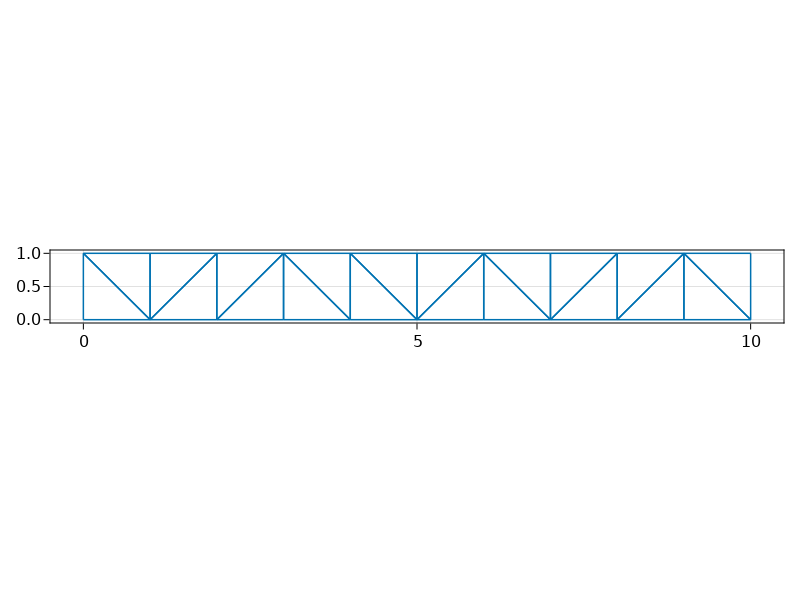

In [12]:
# Define mesh
s = EmbeddedDeltaSet2D("meshes/truss.obj")
sd = dual(s);

# Get boundary masks for BCs #
boundary_e = findall(x -> x != 0, boundary(Val{2},s) * fill(1,ntriangles(s))) # mesh edges
boundary_v = unique(vcat(s[boundary_e,:src],s[boundary_e,:tgt])) # mesh edge vertices

# Define vertices for BC application 
left = filter(x->all((0.0,0.0,0.0) .<= s[x,:point] .<= (0.0,1.0,0.0)), boundary_v) # fixed end
load_v = [22]; # free end load application point

# Plot mesh
fig, ax, ob = wireframe(s)
ax.aspect = AxisAspect(10/1)
fig

## Plot initial string pluck distribution

In [ ]:
x = VForm([p[1] for p in s[:point]]); # x-location along string
y = VForm([p[2] for p in s[:point]]); # y-location 

y1 = collect(range(0.0, 5.0, length=200))
y2 = collect(range(5.0, 0.0, length=(length(x)-200)))

y = [y1; y2]

Plots.plot(x, y, 
     label = "plucked string distribution",
     xlabel="x-coordinate", ylabel="y-coordinate",
     linewidth = 3)


## Add the physics

In [ ]:
c = 2 # wave speed, m/s
γ = -0.75 # damping factor, N*s/m

v = VForm(zeros(nv(s))) # y velocity

lapl = ∇²(Val{0}, sd) # initialize the laplace de-Rham operator

u0 = vcat(x.data, y, v.data) # initial condition for displacement

x_range = 1:length(x)
y_range = (1:length(y)) .+ length(x)
v_range = (1:length(v)) .+ length(x) .+ length(y)

# Physics WITHOUT damping
vf1(du, u, p, t) = begin
    du[v_range] .= (-1*p[1]^2) .* (lapl * u[y_range]) # wave equation
    du[y_range] .= u[v_range] # updates velocity
    du[y_range[left]] = 0.0
    du[y_range[right]] = 0.0
end

# Physics with damping
vf3(du, u, p, t) = begin
    du[v_range] .= (-1*p[1]^2) .* (lapl * u[y_range]) 
    du[y_range] .= u[v_range] 
    du[v_range] .+= p[2] .* u[v_range] # add damping
    du[y_range[left]] = 0.0
    du[y_range[right]] = 0.0
end


## Run the simulation(s)

In [ ]:
# WITHOUT damping 
tspan = (0.0,6.0)
prob = ODEProblem(vf1, u0, tspan, [c])
sol1 = solve(prob);

# with damping
tspan = (0.0,6.0)
prob = ODEProblem(vf3, u0, tspan, [c, γ])
sol3 = solve(prob);

## Plot results (undamped)

In [ ]:
x_loc = [p[1] for p in s[:point]]

y_loc = [sol1(0)[y_range] sol1(1)[y_range] sol1(2)[y_range] sol1(3)[y_range] sol1(4)[y_range] sol1(5)[y_range] sol1(6)[y_range]] 
Plots.plot(x_loc, y_loc, 
    label = ["t=0s" "t=1s" "t=2s" "t=3s" "t=4s" "t=5s" "t=6s" "t=7s" "t-8s" "t=9s" "t=10s"],
    xlabel="x-coordinate", ylabel="y-coordinate",
#     title="Vibrating String System - Free",
    linewidth = 1.5)


savefig("free_stringVib.png")

## Plot results (damped)

In [ ]:
x_loc = [p[1] for p in s[:point]]

Plots.plot(x_loc, 
    [sol3(0)[y_range] sol3(1)[y_range] sol3(2)[y_range] sol3(3)[y_range] sol3(4)[y_range] sol3(5)[y_range] sol3(6)[y_range]], 
    label = ["t=0s" "t=1s" "t=2s" "t=3s" "t=4s" "t=5s" "t=6s" "t=7s" "t=8s" "t=9s" "t=10s"],
    xlabel="x-coordinate",ylabel="y-coordinate",
#     title="Vibrating String System - Damped",
    linewidth = 1.5)

savefig("damped_stringVib.png")

## Record results 

In [ ]:
anim = @animate for t ∈ range(0,10.0, length=50)
    x_loc = [p[1] for p in s[:point]]
    y_loc1 = sol1(t)[y_range]
    y_loc3 = sol3(t)[y_range]
    Plots.plot(x_loc, [y_loc1 y_loc3], 
        label = ["free vibration" "damped vibration"],
        ylim = [-5, 5],
        linewidth = 1.5)
end

# gif(anim, "string.gif", fps = 5)